# MammoDetect: Breast Cancer Detection Using Convolutional Neural Networks (CNN)


### Summary of the CBIS-DDSM Dataset Description:

The CBIS-DDSM (Curated Breast Imaging Subset of DDSM) dataset is a collection of medical images in JPEG format, derived from the original dataset which was 163GB in size. The resolution of the images in the CBIS-DDSM dataset has been maintained to match that of the original dataset. This dataset is primarily focused on breast imaging for mammography.

### Key Dataset Statistics:

* `Number of Studies:` 6,775
* `Number of Series:` 6,775
* `Number of Participants:` 1,566 (Note: The dataset's structure results in multiple patient IDs per participant, making it appear as if there are 6,671 patients according to DICOM metadata, but there are actually 1,566 distinct participants.)
* `Number of Images:` 10,239
* `Modality:` MG (Mammography)
* `Image Size:` 6 GB in JPEG format



In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/cbis-ddsm-breast-cancer-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\khale\.cache\kagglehub\datasets\awsaf49\cbis-ddsm-breast-cancer-image-dataset\versions\1


### Import needed libraries


In [2]:
import os
from os import listdir
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns

import cv2
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import glob
import PIL
import random
import json


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset,random_split
import torchvision.transforms as transforms
from torchvision import models
from torchvision.transforms import RandomRotation, RandomAffine, RandomHorizontalFlip, Resize, ToTensor, Normalize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torch.optim.lr_scheduler import ReduceLROnPlateau

import warnings


random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Suppress only specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)  



### Loading Image


In [3]:
dicom_data = pd.read_csv(f'{path}/csv/dicom_info.csv')
image_dir = f'{path}/jpeg'

In [4]:
dicom_data.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [5]:
dicom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   file_path                                    10237 non-null  object 
 1   image_path                                   10237 non-null  object 
 2   AccessionNumber                              0 non-null      float64
 3   BitsAllocated                                10237 non-null  int64  
 4   BitsStored                                   10237 non-null  int64  
 5   BodyPartExamined                             10237 non-null  object 
 6   Columns                                      10237 non-null  int64  
 7   ContentDate                                  10237 non-null  int64  
 8   ContentTime                                  10237 non-null  float64
 9   ConversionType                               10237 non-null  object 
 10

### Preprocessing & Displaying different types of images

In [6]:
cropped_images = dicom_data.loc[dicom_data.SeriesDescription == 'cropped images', 'image_path']
cropped_images.head()

0     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
Name: image_path, dtype: object

In [7]:
# Replace the path to the images
cropped_images = cropped_images.str.replace('CBIS-DDSM/jpeg', image_dir)
cropped_images.head()

0     C:\Users\khale\.cache\kagglehub\datasets\awsaf...
3     C:\Users\khale\.cache\kagglehub\datasets\awsaf...
6     C:\Users\khale\.cache\kagglehub\datasets\awsaf...
7     C:\Users\khale\.cache\kagglehub\datasets\awsaf...
10    C:\Users\khale\.cache\kagglehub\datasets\awsaf...
Name: image_path, dtype: object

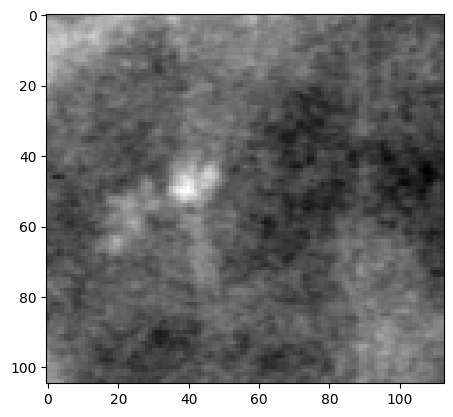

In [8]:
# Display the images
for file in cropped_images[0:10]:
    cropped_images_show = PIL.Image.open(file)
    gray_img= cropped_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

In [9]:
full_mammogram_images = dicom_data[dicom_data.SeriesDescription == 'full mammogram images'].image_path
full_mammogram_images.head()

1     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...
Name: image_path, dtype: object

In [10]:
full_mammogram_images = full_mammogram_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
full_mammogram_images.head()

1     C:\Users\khale\.cache\kagglehub\datasets\awsaf...
2     C:\Users\khale\.cache\kagglehub\datasets\awsaf...
11    C:\Users\khale\.cache\kagglehub\datasets\awsaf...
12    C:\Users\khale\.cache\kagglehub\datasets\awsaf...
15    C:\Users\khale\.cache\kagglehub\datasets\awsaf...
Name: image_path, dtype: object

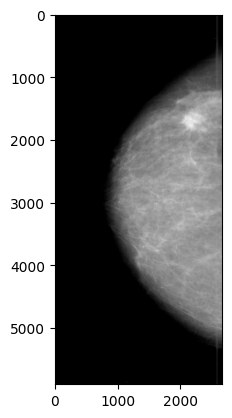

In [11]:
for file in full_mammogram_images[0:10]:
    full_mammogram_images_show = PIL.Image.open(file)
    gray_img= full_mammogram_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

In [12]:
ROI_mask_images = dicom_data[dicom_data.SeriesDescription == 'ROI mask images'].image_path
ROI_mask_images.head()

5     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
8     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
9     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
14    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373...
20    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008...
Name: image_path, dtype: object

In [13]:
ROI_mask_images = ROI_mask_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
ROI_mask_images.head()

5     C:\Users\khale\.cache\kagglehub\datasets\awsaf...
8     C:\Users\khale\.cache\kagglehub\datasets\awsaf...
9     C:\Users\khale\.cache\kagglehub\datasets\awsaf...
14    C:\Users\khale\.cache\kagglehub\datasets\awsaf...
20    C:\Users\khale\.cache\kagglehub\datasets\awsaf...
Name: image_path, dtype: object

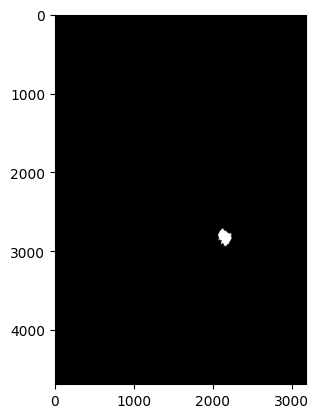

In [14]:
for file  in ROI_mask_images[0:10]:
    ROI_mask_images_show = PIL.Image.open(file)
    gray_img= ROI_mask_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

---

In [15]:
calc_case_df = pd.read_csv(f'{path}/csv/calc_case_description_train_set.csv')

In [16]:
calc_case_df.head(5)

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...


In [17]:
mass_case_df = pd.read_csv(f'{path}/csv/mass_case_description_train_set.csv')

In [18]:
mass_case_df.head(5)

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


### Data Cleaning

In [19]:
dicom_cleaned_data = dicom_data.copy()
dicom_cleaned_data.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [20]:
dicom_cleaned_data.drop(['PatientBirthDate','AccessionNumber','Columns','ContentDate','ContentTime','PatientSex','PatientBirthDate',
                                                'ReferringPhysicianName','Rows','SOPClassUID','SOPInstanceUID',
                                                'StudyDate','StudyID','StudyInstanceUID','StudyTime','InstanceNumber','SeriesInstanceUID','SeriesNumber'],axis =1, inplace=True) 

In [21]:
dicom_cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 21 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   file_path                                    10237 non-null  object
 1   image_path                                   10237 non-null  object
 2   BitsAllocated                                10237 non-null  int64 
 3   BitsStored                                   10237 non-null  int64 
 4   BodyPartExamined                             10237 non-null  object
 5   ConversionType                               10237 non-null  object
 6   HighBit                                      10237 non-null  int64 
 7   LargestImagePixelValue                       10237 non-null  int64 
 8   Laterality                                   9671 non-null   object
 9   Modality                                     10237 non-null  object
 10  PatientID 

In [22]:
dicom_cleaned_data.isna().sum()

file_path                                        0
image_path                                       0
BitsAllocated                                    0
BitsStored                                       0
BodyPartExamined                                 0
ConversionType                                   0
HighBit                                          0
LargestImagePixelValue                           0
Laterality                                     566
Modality                                         0
PatientID                                        0
PatientName                                      0
PatientOrientation                               0
PhotometricInterpretation                        0
PixelRepresentation                              0
SamplesPerPixel                                  0
SecondaryCaptureDeviceManufacturer               0
SecondaryCaptureDeviceManufacturerModelName      0
SeriesDescription                              566
SmallestImagePixelValue        

In [23]:
dicom_cleaned_data['SeriesDescription'].fillna(method = 'bfill', axis = 0, inplace=True)

In [24]:
dicom_cleaned_data['Laterality'].fillna(method = 'bfill', axis = 0, inplace=True)

In [25]:
dicom_cleaned_data.isna().sum()

file_path                                      0
image_path                                     0
BitsAllocated                                  0
BitsStored                                     0
BodyPartExamined                               0
ConversionType                                 0
HighBit                                        0
LargestImagePixelValue                         0
Laterality                                     0
Modality                                       0
PatientID                                      0
PatientName                                    0
PatientOrientation                             0
PhotometricInterpretation                      0
PixelRepresentation                            0
SamplesPerPixel                                0
SecondaryCaptureDeviceManufacturer             0
SecondaryCaptureDeviceManufacturerModelName    0
SeriesDescription                              0
SmallestImagePixelValue                        0
SpecificCharacterSet

In [26]:
Data_cleaning_1 = calc_case_df.copy()
Data_cleaning_1 = calc_case_df.rename(columns={
    'calc type': 'calc_type', 'calc distribution': 'calc_distribution', 'image view': 'image_view',
    'left or right breast': 'left_or_right_breast', 'breast density': 'breast_density',
    'abnormality type': 'abnormality_type'
})
Data_cleaning_1 = Data_cleaning_1.astype({
    'pathology': 'category', 'calc_type': 'category', 'calc_distribution': 'category',
    'abnormality_type': 'category', 'image_view': 'category', 'left_or_right_breast': 'category'
})
Data_cleaning_1.isna().sum()

patient_id                   0
breast_density               0
left_or_right_breast         0
image_view                   0
abnormality id               0
abnormality_type             0
calc_type                   20
calc_distribution          376
assessment                   0
pathology                    0
subtlety                     0
image file path              0
cropped image file path      0
ROI mask file path           0
dtype: int64

In [27]:
Data_cleaning_1['calc_type'] = Data_cleaning_1['calc_type'].bfill(axis=0)
Data_cleaning_1['calc_distribution'] = Data_cleaning_1['calc_distribution'].bfill(axis=0)
Data_cleaning_1.isna().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
calc_type                  0
calc_distribution          0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

In [28]:
Data_cleaning_2 = mass_case_df.copy()
Data_cleaning_2 = mass_case_df.rename(columns={
    'mass shape': 'mass_shape', 'left or right breast': 'left_or_right_breast',
    'mass margins': 'mass_margins', 'image view': 'image_view', 'abnormality type': 'abnormality_type'
})
Data_cleaning_2 = Data_cleaning_2.astype({
    'left_or_right_breast': 'category', 'image_view': 'category', 'mass_margins': 'category',
    'mass_shape': 'category', 'abnormality_type': 'category', 'pathology': 'category'
})
Data_cleaning_2.isna().sum()

patient_id                  0
breast_density              0
left_or_right_breast        0
image_view                  0
abnormality id              0
abnormality_type            0
mass_shape                  4
mass_margins               43
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [29]:
Data_cleaning_2['mass_shape'] = Data_cleaning_2['mass_shape'].bfill(axis=0)
Data_cleaning_2['mass_margins'] = Data_cleaning_2['mass_margins'].bfill(axis=0)
Data_cleaning_2.isna().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

---

### Data Visualization

In [30]:
breast_path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")

print("Path to dataset files:", breast_path)

Path to dataset files: C:\Users\khale\.cache\kagglehub\datasets\paultimothymooney\breast-histopathology-images\versions\1


In [31]:
breast_imgs = glob.glob(f'{breast_path}/IDC_regular_ps50_idx5/**/*.png', recursive = True)

In [32]:
len(breast_imgs)

277524

In [33]:
for imgname in breast_imgs[:5]:
    print(imgname)

C:\Users\khale\.cache\kagglehub\datasets\paultimothymooney\breast-histopathology-images\versions\1/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1001_class0.png
C:\Users\khale\.cache\kagglehub\datasets\paultimothymooney\breast-histopathology-images\versions\1/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1051_class0.png
C:\Users\khale\.cache\kagglehub\datasets\paultimothymooney\breast-histopathology-images\versions\1/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1101_class0.png
C:\Users\khale\.cache\kagglehub\datasets\paultimothymooney\breast-histopathology-images\versions\1/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1151_class0.png
C:\Users\khale\.cache\kagglehub\datasets\paultimothymooney\breast-histopathology-images\versions\1/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1201_class0.png


In [34]:
non_cancer_imgs = []
cancer_imgs = []

for img in breast_imgs:
    if img[-5] == '0' :
        non_cancer_imgs.append(img)
    
    elif img[-5] == '1' :
        cancer_imgs.append(img)

In [35]:
non_cancer_num, cancer_num = len(non_cancer_imgs), len(cancer_imgs)
total_img_num = non_cancer_num + cancer_num

print(f'Number of Images of no cancer: {non_cancer_num}')
print(f'Number of Images of cancer: {cancer_num}')
print(f'Total Number of Images: {total_img_num}')

Number of Images of no cancer: 198738
Number of Images of cancer: 78786
Total Number of Images: 277524


In [36]:
data_insight_1 = pd.DataFrame({'state of cancer' : ['0','1'],'Numbers of Patients' : [198738,78786]})

In [37]:
bar = px.bar(data_frame=data_insight_1, x = 'state of cancer', y='Numbers of Patients', color='state of cancer')
bar.update_layout(title_text='Number of Patients with cancer (1) and patients with no cancer (0)', title_x=0.5)
bar.show()

In [38]:
r= pd.DataFrame(dicom_cleaned_data['SeriesDescription'].value_counts())
r= r.reset_index()
r= r.rename(columns={'SeriesDescription':'SeriesDescription_counts', 'index':'SeriesDescription'})
r

,SeriesDescription_counts,count
0,cropped images,3859
1,ROI mask images,3340
2,full mammogram images,3038


In [39]:
ba_1 = px.bar(data_frame=dicom_cleaned_data, x='SeriesDescription', color='SeriesDescription',
              title='Types of images used')
ba_1.update_layout(title_text='Types of images used', title_x=0.5)
ba_1.show()



from cbis-ddsm-breast-cancer-image-dataset : This study depends on Three types of images ; `cropped images` , `ROI images` , `Full mammogram images` . from this graph we conclude that `cropped images` is the most used between them

In [40]:
f= pd.DataFrame(dicom_cleaned_data['BodyPartExamined'].value_counts())
f= f.reset_index()
f= f.rename(columns={'BodyPartExamined':'BodyPartExamined_counts', 'index':'Breast part Examined'})
f

,BodyPartExamined_counts,count
0,BREAST,9671
1,Left Breast,318
2,Right Breast,248


In [41]:
ba = px.bar(data_frame=f, x="BodyPartExamined_counts", y="count", color="BodyPartExamined_counts")
ba.update_layout(title_text='Breast Parts Examined', title_x=0.5, yaxis=dict(type='log'))
ba.show()

**The Most Part Examined is Breast "All" = left and also right**

In [42]:
data_insight_2 = pd.DataFrame({'abnormality':[Data_cleaning_1.abnormality_type[0],Data_cleaning_2.abnormality_type[0]],
                               'counts_of_abnormalties':[len(Data_cleaning_1),len(Data_cleaning_2)]})
data_insight_2

,abnormality,counts_of_abnormalties
0,calcification,1546
1,mass,1318


In [43]:
bar_2 =px.bar(data_frame=data_insight_2, x = 'abnormality', y='counts_of_abnormalties', color = 'abnormality')
bar_2.update_layout(title_text='Types of abnormalites of cancer', title_x=0.5)
bar_2.show()

from this graph: 
There are two abnormalities of breast cancer:
- Calcification abnormality
- Mass abnormality 

**Most cases are with calcification abnormalities**

In [44]:
x = Data_cleaning_1.left_or_right_breast.value_counts().RIGHT
y = Data_cleaning_1.left_or_right_breast.value_counts().LEFT
print(x,y)

728 818


In [45]:
data_insight_3 = pd.DataFrame({'left_or_right_breast':['RIGHT','LEFT'] , 'Counts':[x,y]})
data_insight_3

,left_or_right_breast,Counts
0,RIGHT,728
1,LEFT,818


In [46]:
insight_3 = px.bar(data_insight_3, y= 'Counts', x='left_or_right_breast',color = 'left_or_right_breast')
insight_3.update_layout(title_text=' clacification cancer position of the breasts ', title_x=0.5)
insight_3.show()

**For calcification cancer, most cases are usually in the left breast.**

In [47]:
z = pd.DataFrame(Data_cleaning_1['calc_type'].value_counts())
z = z.reset_index()
z= z.rename(columns={'calc_type':'calc_type_counts'})
z

,calc_type_counts,count
0,PLEOMORPHIC,664
1,AMORPHOUS,139
2,PUNCTATE,106
3,LUCENT_CENTER,93
4,VASCULAR,82
5,FINE_LINEAR_BRANCHING,77
6,COARSE,35
7,ROUND_AND_REGULAR-LUCENT_CENTER,33
8,PLEOMORPHIC-FINE_LINEAR_BRANCHING,28
9,ROUND_AND_REGULAR-LUCENT_CENTER-PUNCTATE,24


**Calcification cancer has 45 types, the majority of which are PLEOMORPHIC.**

#### Setup Transformers

In [48]:
transform = transforms.Compose([
    transforms.Resize((50, 50)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

#### Creating Custom Class

In [49]:
class BreastCancerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = PIL.Image.open(img_path).convert("RGB") 
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [50]:
# Create labeled lists for dataset
image_paths = non_cancer_imgs + cancer_imgs
labels = [0] * non_cancer_num + [1] * cancer_num  # 0:non-cancer, 1:cancer


dataset = BreastCancerDataset(image_paths, labels, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

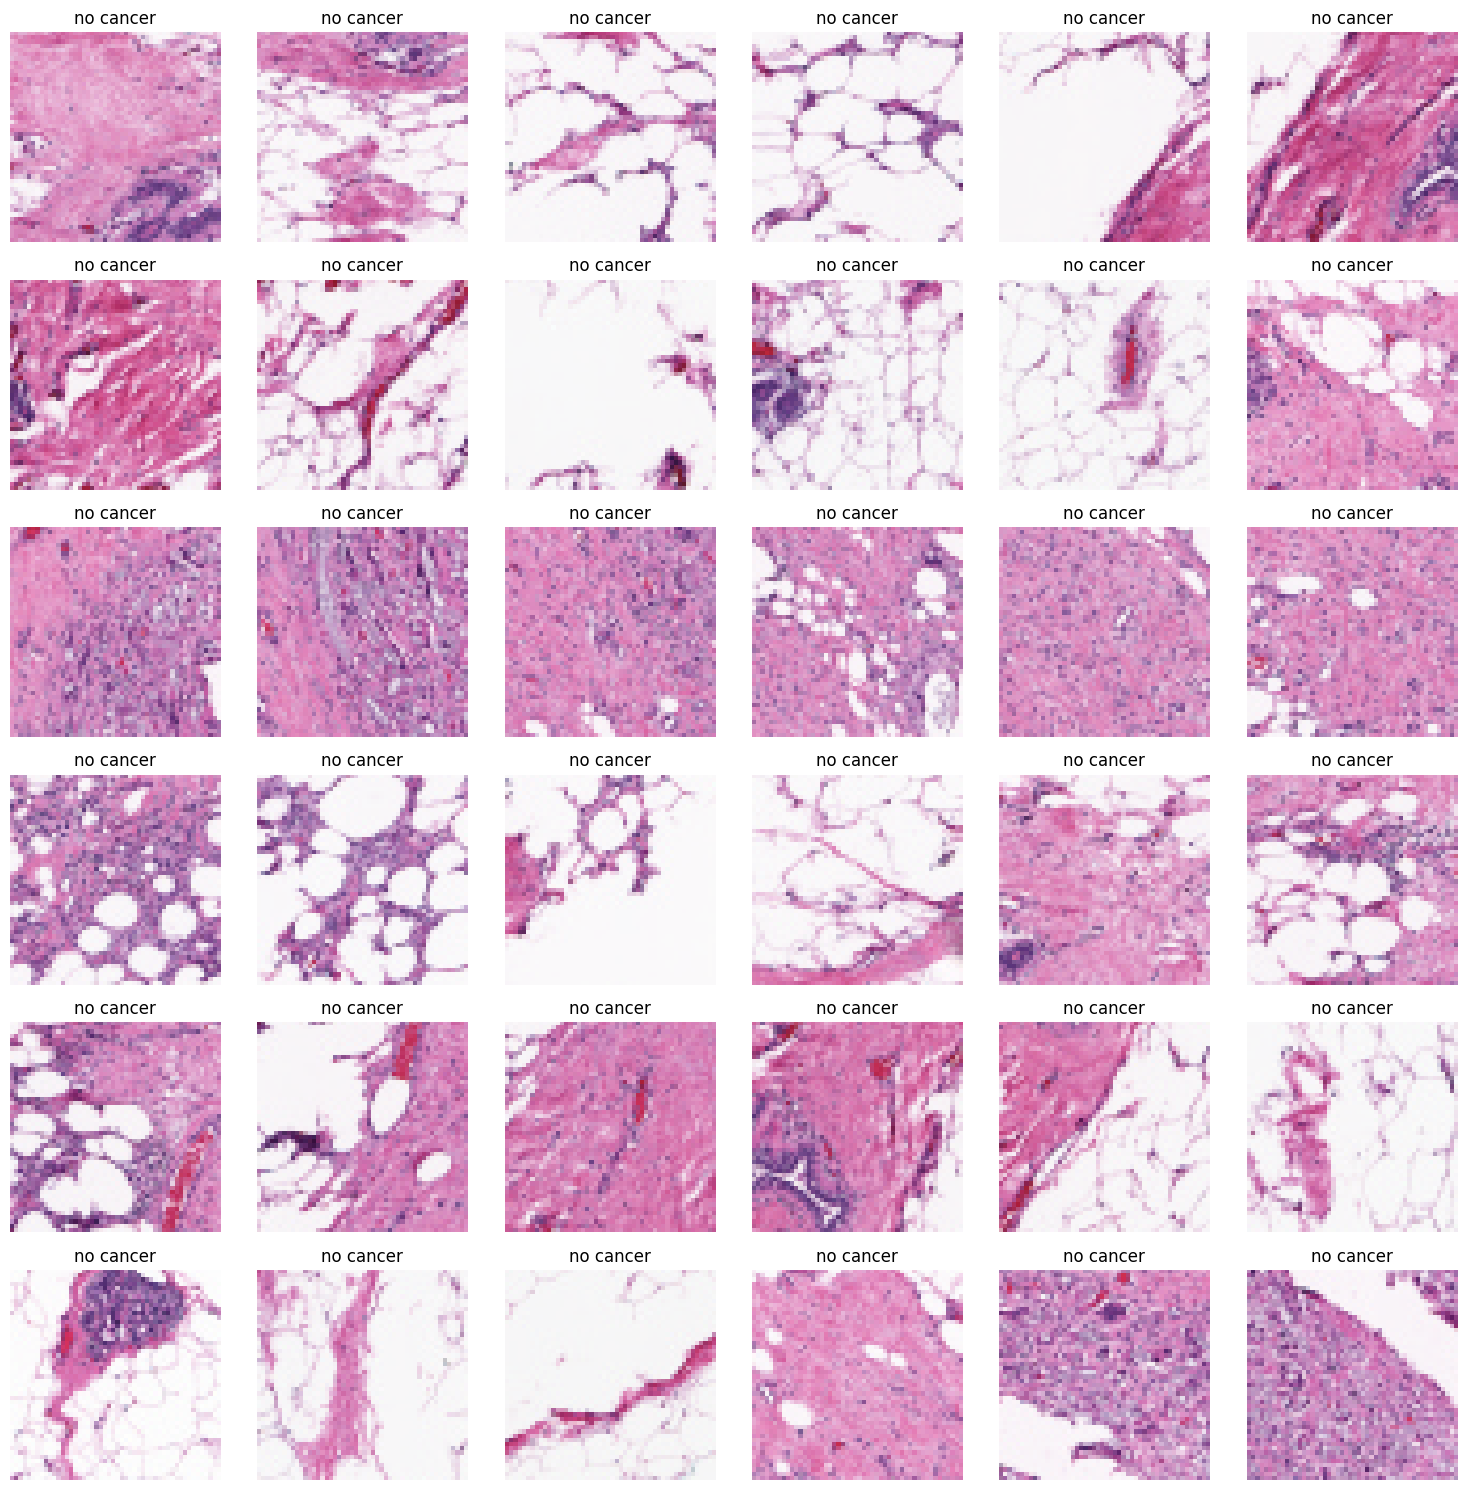

In [51]:
# Plot a few sample images
fig, axs = plt.subplots(6, 6, figsize=(15, 15))
axs = axs.ravel()

for i in range(36):  
    img, label = dataset[i]
    img = img.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Re-scale image for display
    axs[i].imshow(img)
    axs[i].set_title('cancer' if label == 1 else 'no cancer')
    axs[i].axis('off')

plt.tight_layout()
plt.show()


## Data Modeling

### Data Preparation


In [52]:
some_non_img = random.sample(non_cancer_imgs, len(non_cancer_imgs))
some_can_img = random.sample(cancer_imgs, len(cancer_imgs))

non_img_arr = []  # Array for non-cancer images
can_img_arr = []  # Array for cancer images

for img in some_non_img:
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])

for img in some_can_img:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])    


In [53]:
# Debugging
#----------#

def get_shape(lst):
    if isinstance(lst, list):
        return [len(lst)] + get_shape(lst[0]) if lst else []
    return []

print(get_shape(non_img_arr))
print(get_shape(can_img_arr))
print("total images:", get_shape(non_img_arr+can_img_arr))


for img, label in non_img_arr + can_img_arr:
    if img.shape != (50, 50, 3):
        print("Inconsistent shape:", img.shape)


[198738, 2]
[78786, 2]
total images: [277524, 2]


### Data Splitting and Subsampling

In [54]:
combined_img_arr = non_img_arr + can_img_arr
random.shuffle(combined_img_arr)

images = [item[0] for item in combined_img_arr]  # Extract only the image arrays
labels = [item[1] for item in combined_img_arr]  # Extract only the labels

# Convert images and labels to NumPy arrays
X = np.array(images)  
y = np.array(labels)

# Check the shapes
print('X shape:', X.shape)  
print('y shape:', y.shape)  

X shape: (277524, 50, 50, 3)
y shape: (277524,)


### Data Splitting


In [55]:
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

y_train = np.argmax(y_train, axis=1) if len(y_train.shape) > 1 else y_train
y_test = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test

# Check shapes
print('X_train shape:', X_train.shape)  
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)  
print('y_test shape:', y_test.shape)

X_train shape: (222019, 50, 50, 3)
X_test shape: (55505, 50, 50, 3)
y_train shape: (222019,)
y_test shape: (55505,)


### Data Augmentation

In [56]:
# Augment the data
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop((50, 50), scale=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

# Define test transform without augmentation
test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((50, 50)),
    transforms.ToTensor()
])


### Custom Dataset Class to handle transformers

In [57]:
class CancerDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label

train_dataset = CancerDataset(X_train, y_train, transform=data_transforms)
test_dataset = CancerDataset(X_test, y_test, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Model Archeticture:

In [58]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        # Calculate the flattened size after all convolutional and pooling layers
        self.flattened_size = self._get_flattened_size()
        
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 2)

    def _get_flattened_size(self):
        # Pass a dummy input through the convolutional layers to calculate the output size
        x = torch.randn(1, 3, 50, 50)
        x = self.pool(nn.ReLU()(self.bn1(self.conv1(x))))
        x = self.pool(nn.ReLU()(self.bn2(self.conv2(x))))
        x = self.pool(nn.ReLU()(self.bn3(self.conv3(x))))
        x = self.pool(nn.ReLU()(self.bn4(self.conv4(x))))
        return x.view(-1).size(0)  # Flatten and get the size

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.bn1(self.conv1(x))))
        x = self.pool(nn.ReLU()(self.bn2(self.conv2(x))))
        x = self.pool(nn.ReLU()(self.bn3(self.conv3(x))))
        x = self.pool(nn.ReLU()(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)  # Flatten, preserving batch size
        x = self.dropout(nn.ReLU()(self.fc1(x)))
        x = self.fc2(x)
        return x

In [59]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print(torch.version.cuda)  # Should display the CUDA version
print(torch.cuda.is_available())  # Should return True if CUDA is properly set up


Using device: cuda
11.8
True


### Training and Evaluation Loop

In [60]:
train_flag = False  # Set to False to load a saved model and history


model_path = "cnn_model.pth"
history_path = "training_history.json"

# Instantiate the model, define loss function and optimizer
model = CNNModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, verbose=True)


train_acc_history = []
train_loss_history = []
val_acc_history = []
val_loss_history = []



def load_trained_model(model, model_path):

    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))  # Load model weights
        model.eval()  # Set model to evaluation mode
        print("Model loaded from", model_path)
    else:
        print("Model file not found. Please train the model first.")
        model = None  # Return None if the model file does not exist

    return model


if not train_flag:
    load_trained_model(model, model_path)

    if os.path.exists(history_path):
        with open(history_path, 'r') as f:
            history = json.load(f)
            train_acc_history = history["train_acc_history"]
            train_loss_history = history["train_loss_history"]
            val_acc_history = history["val_acc_history"]
            val_loss_history = history["val_loss_history"]
        print("History loaded from", history_path)
    else:
        print("History file not found. Please train the model first.")

else:
    # Training loop with early stopping
    num_epochs = 25
    best_val_loss = float('inf')
    early_stop_count = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device) 
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        
        train_loss_history.append(train_loss)
        train_acc_history.append(train_accuracy)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(test_loader.dataset)
        val_accuracy = val_correct / val_total
        val_loss_history.append(val_loss)
        val_acc_history.append(val_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
            f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        # Learning rate scheduler and early stopping
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_count = 0
        else:
            early_stop_count += 1
            if early_stop_count >= 5:
                print("Early stopping triggered.")
                break
            
        torch.save(model.state_dict(), model_path)
        history = {
            "train_acc_history": train_acc_history,
            "train_loss_history": train_loss_history,
            "val_acc_history": val_acc_history,
            "val_loss_history": val_loss_history,
        }
        with open(history_path, 'w') as f:
            json.dump(history, f)



Model loaded from cnn_model.pth
History loaded from training_history.json


c:\Users\khale\Desktop\MammoDetect\classifier_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.



### Plotting and Training Validation Accuracy and Loss


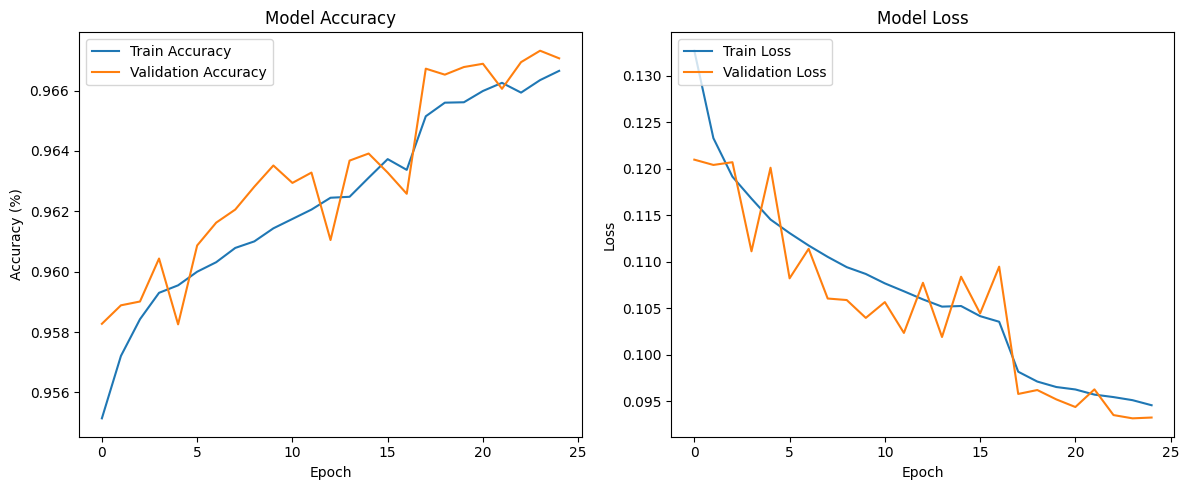

In [61]:
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


##  Final evaluation on test data

### Inference and Confusion Matrix


Final Accuracy of the model on the test set: 83.68%


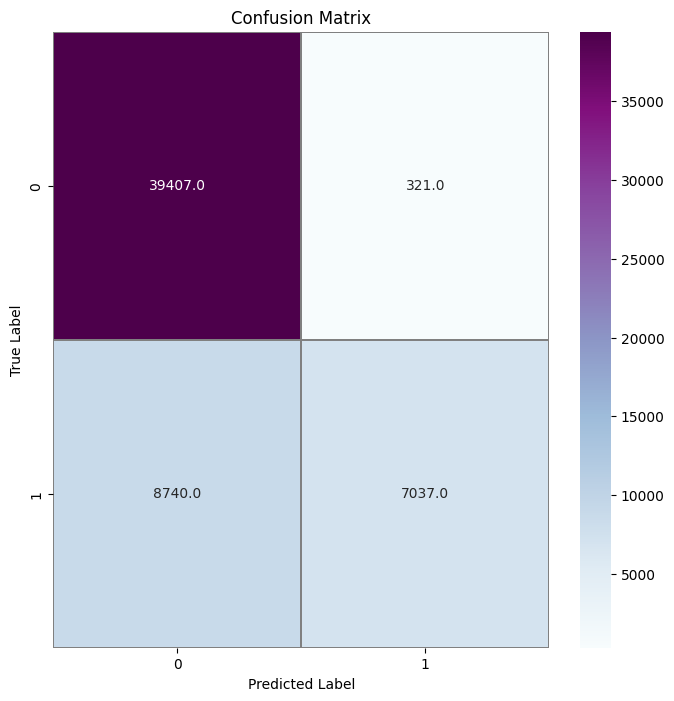

Predictions for the test set: [0 0 0 ... 0 0 0]


In [62]:
model.eval()


correct = 0
total = 0
all_preds = []
all_labels = []
predictions = []


with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

# Calculate and print final accuracy
accuracy = 100 * correct / total
print(f"Final Accuracy of the model on the test set: {accuracy:.2f}%")

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt=".1f")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Convert predictions list to a NumPy array for further analysis if needed
predictions = np.array(predictions)

# Print predictions
print("Predictions for the test set:", predictions)


### Testing the Model

Predicted Diagnosis: Non-Cancerous
Calcification Type: No Calcification
True Diagnosis: Non-Cancerous


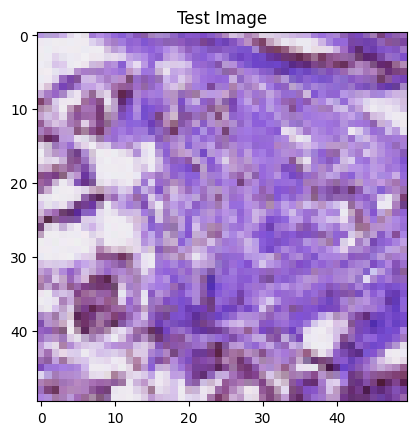

In [63]:
class_labels = {
    0: 'Non-Cancerous',
    1: 'Cancerous',
}


calcification_types = {
    0: 'No Calcification',
    1: 'PLEOMORPHIC',
    2: 'AMORPHOUS',
    3: 'PUNCTATE',
    4: 'LUCENT_CENTER',
    5: 'VASCULAR',
    6: 'FINE_LINEAR_BRANCHING',
    7: 'COARSE',
    8: 'ROUND_AND_REGULAR-LUCENT_CENTER',
    9: 'PLEOMORPHIC-FINE_LINEAR_BRANCHING',
    10: 'ROUND_AND_REGULAR-LUCENT_CENTER-PUNCTATE',
    11: 'ROUND_AND_REGULAR-EGGSHELL',
    12: 'PUNCTATE-PLEOMORPHIC',
    13: 'DYSTROPHIC',
    14: 'LUCENT_CENTERED',
    15: 'ROUND_AND_REGULAR-LUCENT_CENTER-DYSTROPHIC',
    16: 'ROUND_AND_REGULAR',
    17: 'ROUND_AND_REGULAR-LUCENT_CENTERED',
    18: 'AMORPHOUS-PLEOMORPHIC',
    19: 'LARGE_RODLIKE-ROUND_AND_REGULAR',
    20: 'PUNCTATE-AMORPHOUS',
    21: 'COARSE-ROUND_AND_REGULAR-LUCENT_CENTER',
    22: 'VASCULAR-COARSE-LUCENT_CENTERED',
    23: 'LUCENT_CENTER-PUNCTATE',
    24: 'ROUND_AND_REGULAR-PLEOMORPHIC',
    25: 'EGGSHELL',
    26: 'PUNCTATE-FINE_LINEAR_BRANCHING',
    27: 'VASCULAR-COARSE',
    28: 'ROUND_AND_REGULAR-PUNCTATE',
    29: 'SKIN-PUNCTATE-ROUND_AND_REGULAR',
    30: 'SKIN-PUNCTATE',
    31: 'COARSE-ROUND_AND_REGULAR-LUCENT_CENTERED',
    32: 'PUNCTATE-ROUND_AND_REGULAR',
    33: 'LARGE_RODLIKE',
    34: 'AMORPHOUS-ROUND_AND_REGULAR',
    35: 'PUNCTATE-LUCENT_CENTER',
    36: 'SKIN',
    37: 'VASCULAR-COARSE-LUCENT_CENTER-ROUND_AND_REGULA',
    38: 'COARSE-PLEOMORPHIC',
    39: 'ROUND_AND_REGULAR-PUNCTATE-AMORPHOUS',
    40: 'COARSE-LUCENT_CENTER',
    41: 'MILK_OF_CALCIUM',
    42: 'COARSE-ROUND_AND_REGULAR',
    43: 'SKIN-COARSE-ROUND_AND_REGULAR',
    44: 'ROUND_AND_REGULAR-AMORPHOUS',
    45: 'PLEOMORPHIC-PLEOMORPHIC'
}


def img_plot(arr, index=0):
    
    plt.title('Test Image')
    plt.imshow(arr[index])
    # plt.title('Test Image')
    # plt.axis('off')
    # plt.show()


# Image index to test
index = 92 

img_plot(X_test, index)

# Extract a single image from X_test based on the specified index
input_image = X_test[index:index+1]
input_tensor = torch.tensor(input_image).float().to(device)  
input_tensor /= 255.0
if input_tensor.shape[1] != 3:  
    input_tensor = input_tensor.permute(0, 3, 1, 2) # Change the shape to [batch_size, channels, height, width]

input_tensor = input_tensor.contiguous()    # Ensure memory is contiguous

model.eval() 
with torch.no_grad():
    output = model(input_tensor) 
    predicted_class_index = output.argmax(dim=1).item()  


true_class_index = y_test[index].item()  

# Get the predicted and true labels
predicted_label = class_labels[predicted_class_index]
true_label = class_labels[true_class_index]

# Get the calcification type based on the predicted class index (modify as needed)
calcification_type = calcification_types.get(predicted_class_index, "Unknown")

# Print the prediction result with calcification type
print('Predicted Diagnosis:', predicted_label)
print('Calcification Type:', calcification_type)
print('True Diagnosis:', true_label)


### Inference Function

Model loaded from cnn_model.pth


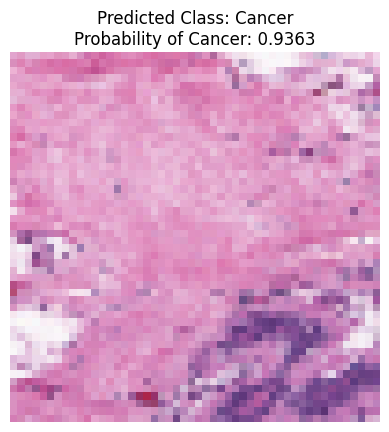

Predicted Class: Cancer, Probability of Cancer: 0.9363


In [64]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# Define the inference function
def infer_image(model, image_path, target_size=(50, 50)):
    """
    Load an image, preprocess it, and run inference with a trained model.
    
    Parameters:
    - model: Trained PyTorch model
    - image_path: Path to the image file
    - target_size: Target size for resizing the image (default: (50, 50))
    
    Returns:
    - predicted_class: Predicted label ('Cancer' or 'Normal')
    - cancer_probability: Probability of the image being cancerous
    """
    
    # Load and preprocess the image
    try:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
        img = cv2.resize(img, target_size)  
        img_array = img / 255.0  # Normalize pixel values

        # Convert image to tensor
        img_batch = np.expand_dims(img_array, axis=0)  
        img_batch = np.transpose(img_batch, (0, 3, 1, 2))  
        img_tensor = torch.tensor(img_batch, dtype=torch.float32).to(device) 
        img_tensor = img_tensor.contiguous()

    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None, None
    
    # Set the model to evaluation mode and make predictions
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        cancer_probability = torch.sigmoid(output[0][0]).item()  # Apply sigmoid for binary classification

    # Determine the predicted class based on probability
    predicted_class = "Cancer" if cancer_probability >= 0.5 else "Normal"
    
    # Display the image with prediction
    plt.imshow(img)
    plt.title(f'Predicted Class: {predicted_class}\nProbability of Cancer: {cancer_probability:.4f}')
    plt.axis('off')
    plt.show()
    
    return predicted_class, cancer_probability

# Example usage:
model = load_trained_model(model, model_path)
image_path = f'{breast_path}/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001_y1001_class0.png'
predicted_class, cancer_probability = infer_image(model, image_path)
print(f'Predicted Class: {predicted_class}, Probability of Cancer: {cancer_probability:.4f}')
